In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

In [3]:
countries_data = pd.read_csv("../Data/Processed/worried_data_processed.csv")

In [4]:
X_PCA = np.load("../Data/Processed/X_PCA.npy")

# Clustering
The main objective of this project is to compare country groups obtained through unsupervised clustering based on Findex data to:
- World Bank classification by income (4 groups),
- Division into Frontier, Emerging, and Developed Markets (3 groups),
- The Economist Democracy Index (4 groups, 10 subgroups).

The World Bank divides countries into four groups, so the aim is to obtain four clusters. The Economist Democracy Index categorizes countries into four main groups based on scores ranging from 0 to 10. The first three groups each have two subgroups, and the last one has four subgroups. Therefore, the aim is not only to obtain four clusters but also to obtain 10 clusters. The division into Frontier, Emerging, and Developed Markets consists of three groups. Additionally, Emerging Markets are sometimes subdivided into various subgroups.

# K-means

In [41]:
K_min = 3
K_max = 21
cluster_no = list(range(K_min, K_max))
wgss = {}
silh_score = {}
neg_silh_score = {}
for K in cluster_no:
    # uses data after PCA with the no of principal components representing 90% of the explained variance
    kmeans = KMeans(n_clusters = K, n_init = 30).fit(X_PCA[:, 0:3])
    wgss[K] = kmeans.inertia_
    silh_score[K] = silhouette_score(X_PCA, kmeans.labels_)
    neg_silh_score[K] = np.sum(silhouette_samples(X_PCA, kmeans.labels_) < 0)

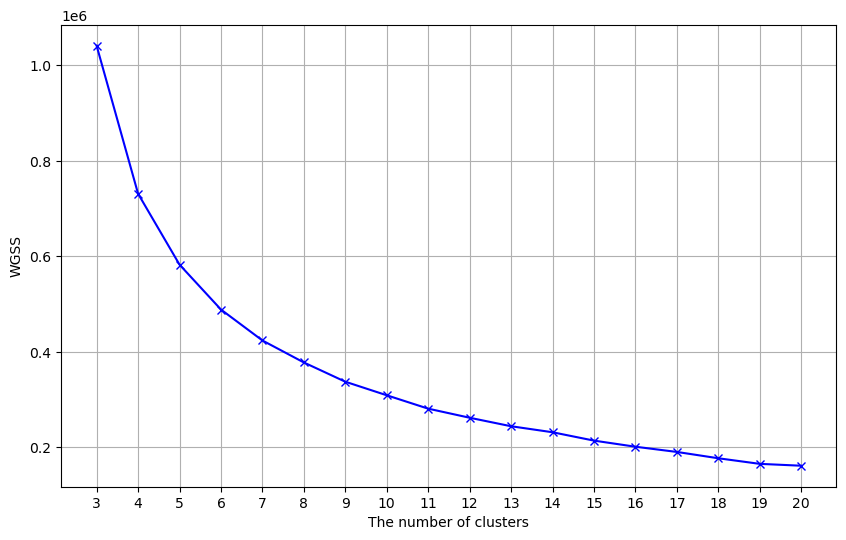

In [42]:
plt.figure(figsize = (10,6))
plt.plot(wgss.keys(), wgss.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("WGSS")
plt.grid(True)

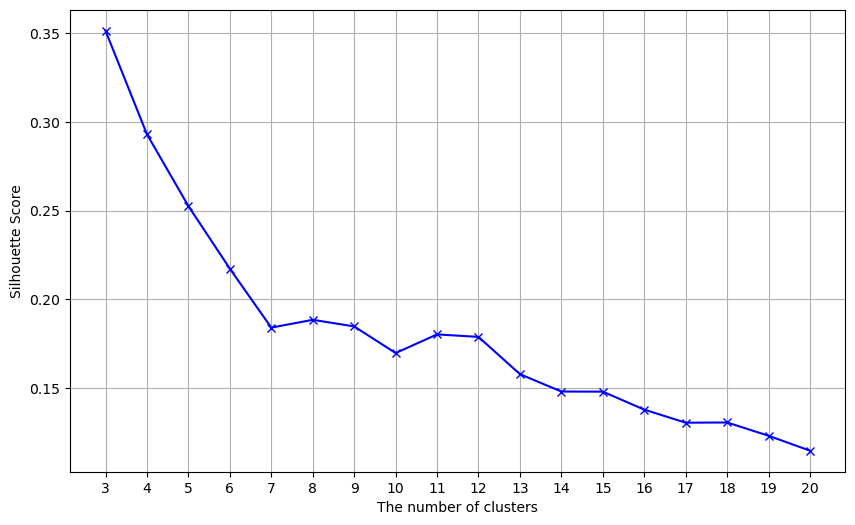

In [43]:
plt.figure(figsize = (10,6))
plt.plot(silh_score.keys(), silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

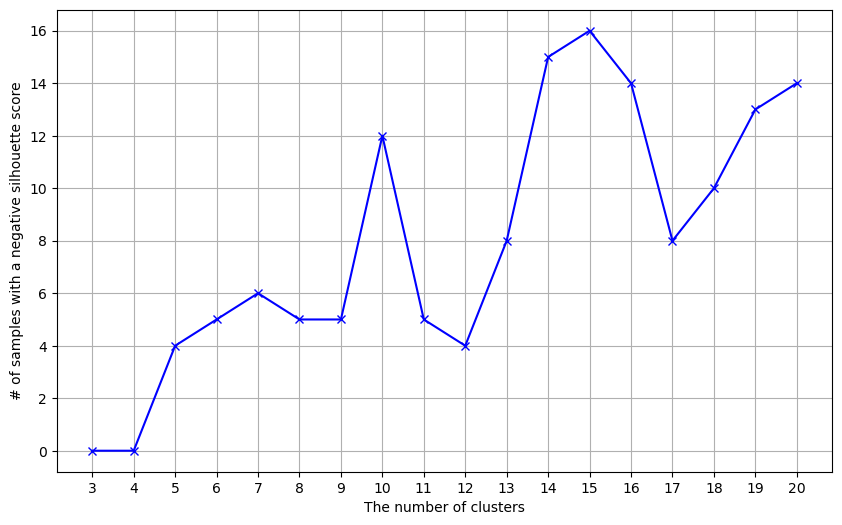

In [44]:
plt.figure(figsize = (10,6))
plt.plot(neg_silh_score.keys(), neg_silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("# of samples with a negative silhouette score")
plt.grid(True)

## Analysis of the Number of Clusters in K-means
Based on the WGSS, silhouette score, and the number of samples with a negative score, dividing the data into 3 or 4 clusters appears to be stable. The WGSS "elbow" occurs at 5 or 6 clusters, while dividing into 10 clusters results in relatively low WGSS, which may indicate unstable clustering.

The "elbow" of the silhouette score occurs around 7 clusters, further suggesting that 3 and 4 clusters provide stable clustering, whereas 10 clusters appear to be an unstable option.

Almost all samples have a positive silhouette score for 3 and 4 clusters, with fewer than 10 samples having a negative silhouette score for 10 clusters (less than 7% of samples).



## The Influence of K-means Parameters on the Robustness of Clusters
K-means clustering will be performed N = 50 times, and the label assignments for each country will be analyzed. The clustering is considered stable when each country is assigned the same label in almost every iteration.

There is no guarantee that the same cluster will retain the same label across different K-means iterations. To address this, label realignment is performed by solving the assignment problem, which involves maximizing the trace of the confusion matrix between the reference clustering and subsequent iterations. This ensures that the labels are consistently matched to the corresponding clusters across all runs.

In [45]:
# Used to realign labels from clustering to compare clusters
# When K-means is used for clustering, the same clusters can be differently labeled.
# Clusters which align the most are labeled according to the reference.
# reference and labels are each a vector of labels
def find_label_alignement(reference, labels):
    # the number of clusters
    no_clusters = len(set(labels))
    if no_clusters != len(set(reference)):
        print("Relabeling impossible, no of clusters in labels differs from the no of lables in the reference.")
        return None
    # build a confusion matrix (C[i,j]: element labeled j is labeled i in the reference
    cm = confusion_matrix(reference, labels)
    # scipy.optimize.linear_sum_assignment solves the assignement problem
    # here is finds such a permutation of the labels, which maximizes the trace (data points correctly assigned)
    return linear_sum_assignment(cm, maximize = True)

In [46]:
def relabel_clustering(reference, labels, mapping):
    labels_match = (mapping[0] == mapping[1])
    if np.all(labels_match):
        #print("Labels match.")
        return labels
    relabeled = np.array(labels, copy = True)
    for i in range(len(mapping[0])):
        if labels_match[i] == False:
            #print("Changing", mapping[1][i], "to", mapping[0][i])
            mask = (labels == mapping[1][i])
            relabeled[mask] = mapping[0][i]
    return relabeled

In [47]:
# labels is a list of length number of clustering iterations of numpy arrays of lenght number of data points
def align_labels(clusters):
    reference_labels = clusters[0]
    aligned_clusters = [clusters[0]]
    for n in range(1, len(clusters)):
        mapping = find_label_alignement(reference_labels, clusters[n])
        aligned_clusters.append(relabel_clustering(reference_labels, clusters[n], mapping))
    # each effect of the clustering is in a row
    aligned_clusters = np.array(aligned_clusters)
    return aligned_clusters

In [48]:
N = 50
cluster_no = list(range(3, 11))
#cluster_no = [4]
n_init_param = list(range(10, 111, 20))
#n_init_param = [1, 10]

mean_wgss = {}
mean_silh_score = {}

for K in cluster_no:
    for inits in n_init_param:
        labels = []
        iter_wgss = []
        iter_silh_score = []
        for n in range(N):
            # uses data after PCA with the no of principal components representing 90% of the explained variance
            kmeans = KMeans(n_clusters = K, n_init = inits).fit(X_PCA[:, 0:3])
            labels.append(kmeans.labels_)
            iter_wgss.append(kmeans.inertia_)
            iter_silh_score.append(silhouette_score(X_PCA, kmeans.labels_))
        mean_wgss[K, inits] = np.mean(iter_wgss)
        mean_silh_score[K, inits] = np.mean(iter_silh_score)

        #aligned_labels = align_labels(labels)

        #if np.all(aligned_labels == aligned_labels[0,:]):
        #    print("All elements are clustered the same")
        #else:
        #    print("There are differences in clustering")

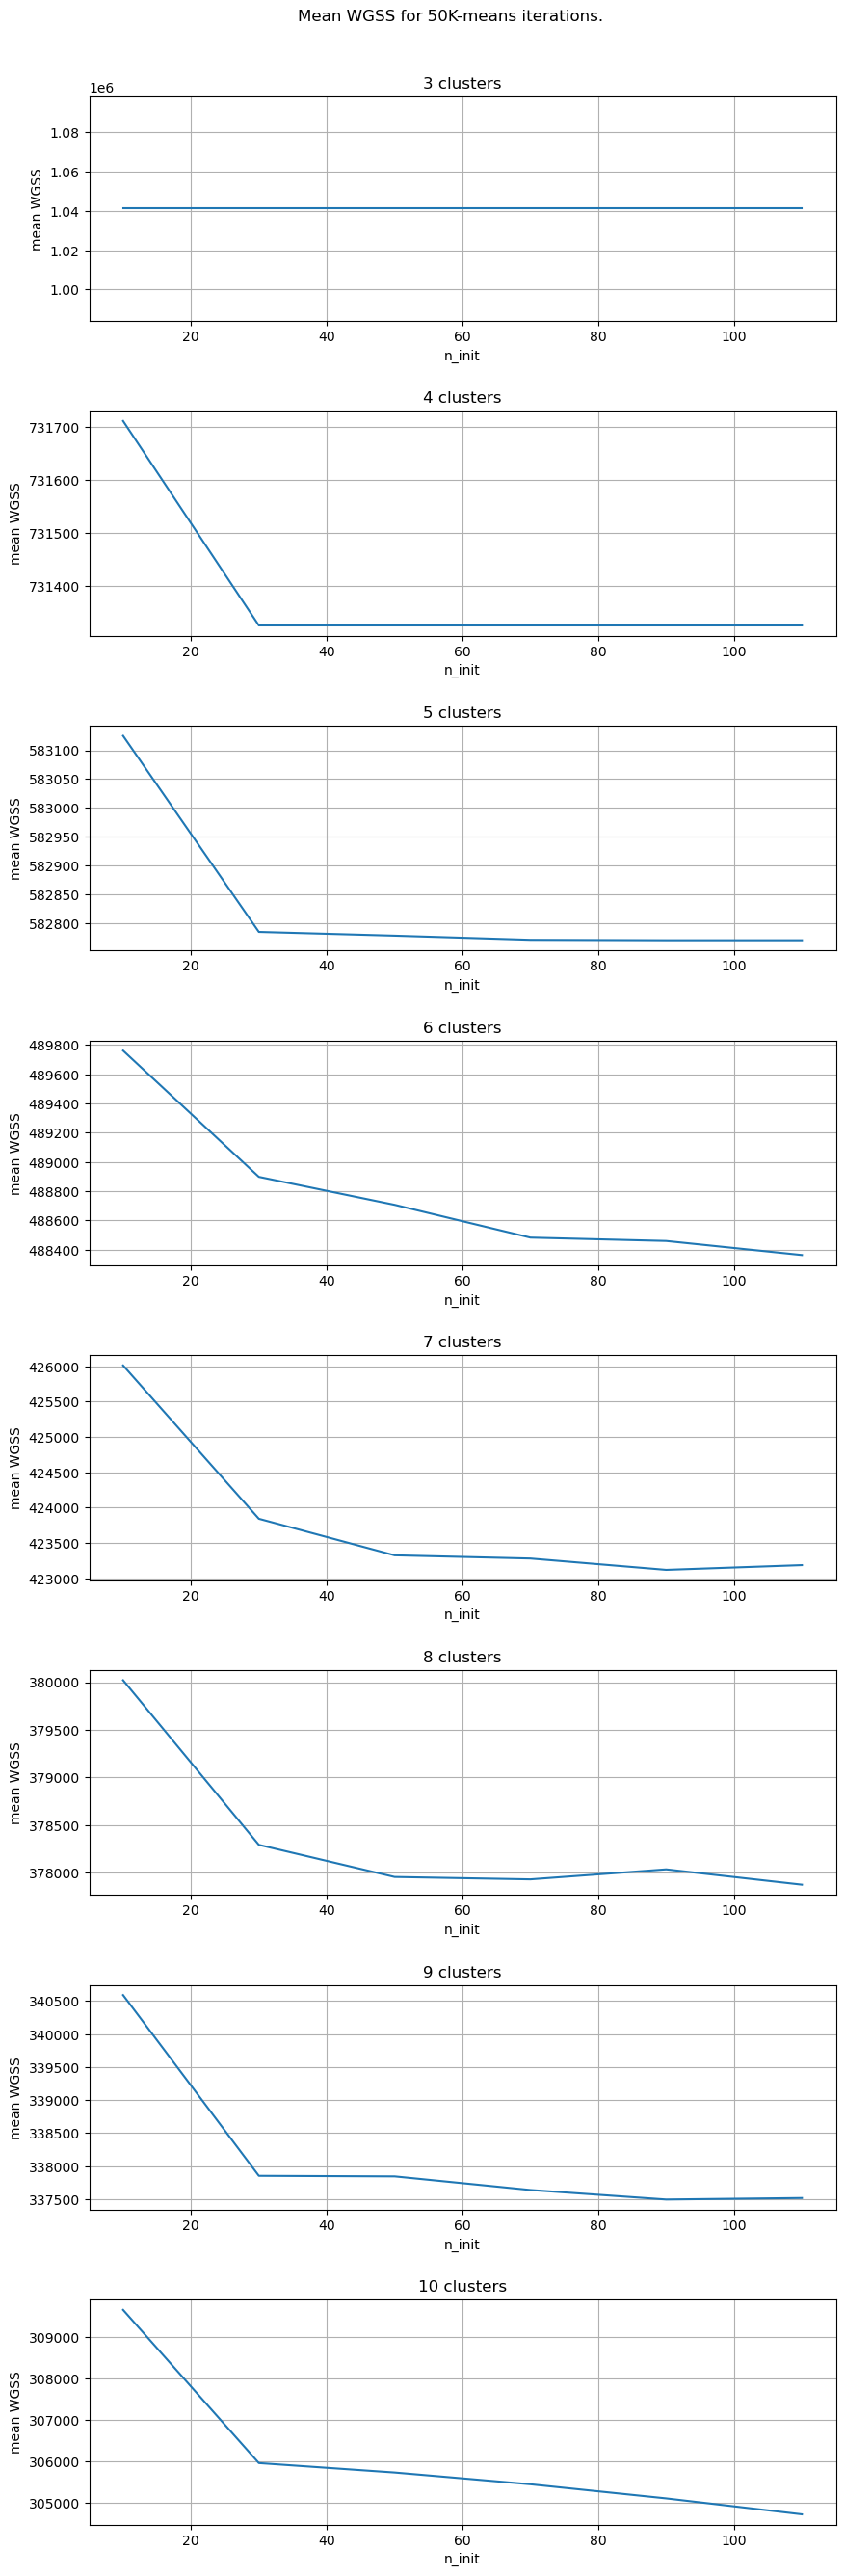

In [63]:
plot_no = len(cluster_no)
fig, ax = plt.subplots(plot_no, figsize = (10,30))
plot_title = " ".join(["Mean WGSS for", str(N), "K-means iterations."])
fig.suptitle(plot_name)
fig.subplots_adjust(top = 0.95, hspace = 0.4)
for i in range(plot_no):
    temp = {key[1]: val for key, val in mean_wgss.items() if key[0] == cluster_no[i]}
    ax[i].plot(temp.keys(), temp.values())
    subplot_title = " ".join([str(cluster_no[i]), "clusters"])
    ax[i].set_title(subplot_title)
    ax[i].set_xlabel("n_init")
    ax[i].set_ylabel("mean WGSS")
    ax[i].grid(True)

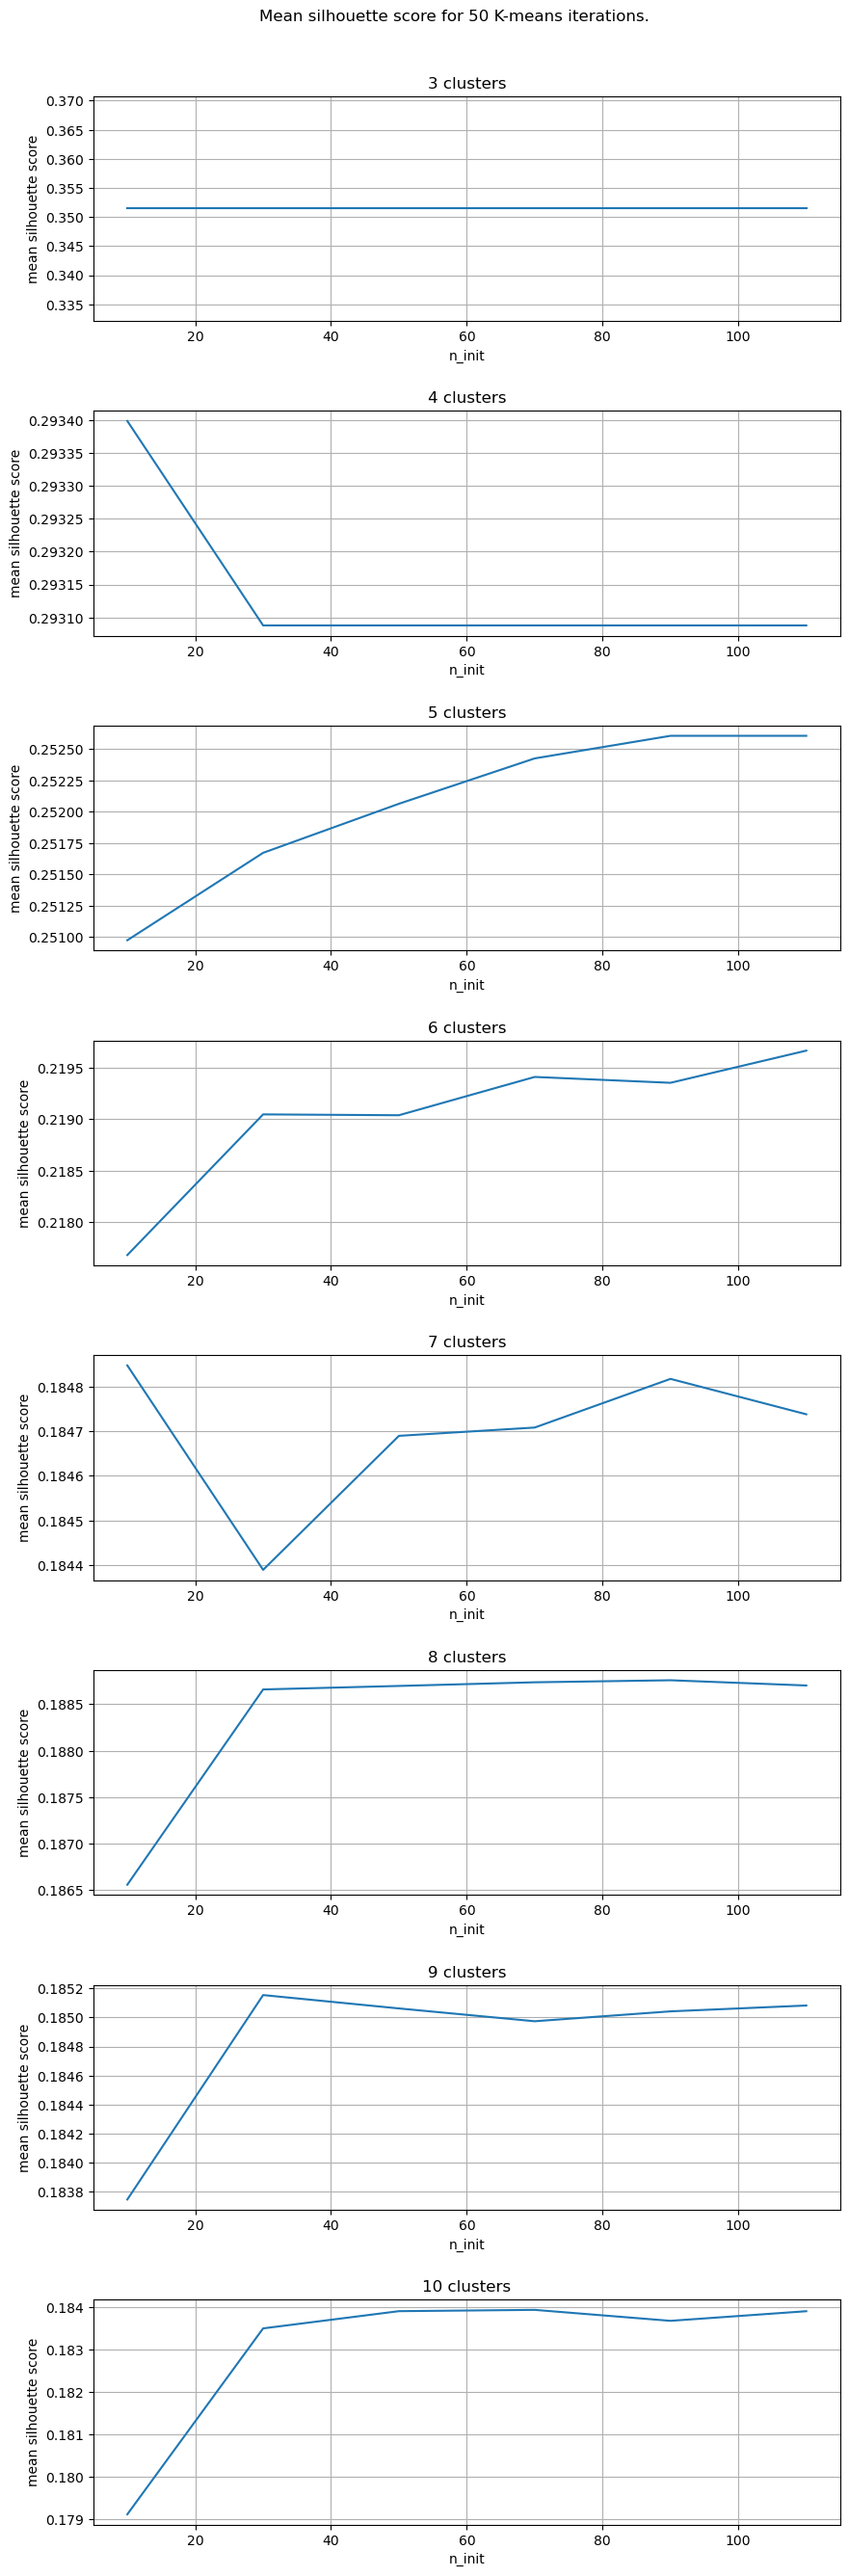

In [66]:
plot_no = len(cluster_no)
fig, ax = plt.subplots(plot_no, figsize = (10,30))
plot_title = " ".join(["Mean silhouette score for", str(N), "K-means iterations."])
fig.suptitle(plot_title)
fig.subplots_adjust(top = 0.95, hspace = 0.4)
for i in range(plot_no):
    temp = {key[1]: val for key, val in mean_silh_score.items() if key[0] == cluster_no[i]}
    ax[i].plot(temp.keys(), temp.values())
    subplot_title = " ".join([str(cluster_no[i]), "clusters"])
    ax[i].set_title(subplot_title)
    ax[i].set_xlabel("n_init")
    ax[i].set_ylabel("mean silhouette score")
    ax[i].grid(True)

### Observations on the Influence of the n_init Parameter on the Robustness of Clustering
With an increasing number of random initializations, the solution quality—measured by WGSS and silhouette score—improves. For both WGSS and silhouette score, there appears to be an “elbow” at n_init = 30 for all cluster numbers greater than or equal to four.

The n_init parameter has no effect on clustering into three groups, which appears stable. As the number of clusters increases, there seem to be more local minima that K-means can get stuck in; however, with more random initializations, the algorithm is more likely to find optimal solutions.

